In [1]:
import numpy as np, matplotlib.pyplot as plt
import os
from scipy import interpolate
from astropy.convolution import convolve_fft, Gaussian1DKernel
from glob import glob

In [2]:
msfire = np.loadtxt('Flux_cal_JHK_2M2255-3118.txt')
wave = msfire[:, 0] # Å
wave_um = msfire[:, 0] * 1e-4 # µm
flux = msfire[:, 1]
flux_spec = msfire[:, 1] * 1e-11 # erg/cm^2/s/A to W/m^2/um (species units)
unc = msfire[:, 2]
unc_spec = msfire[:, 2] * 1e-11

In [64]:
target = 'WISE J225540.75-311842.0'
target_short = 'WISE J225540'

file_name = '/Users/bseamons/Documents/Research/Flux_cal_JHK_2M2255-3118.txt'

spex_path_full = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/'
spex_models = glob(os.path.join(spex_path_full, '*.txt'))

spex_path_T6 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6/'
spex_T6 = glob(os.path.join(spex_path_T6, '*.txt'))

spex_path_T65 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6.5/'
spex_T65 = glob(os.path.join(spex_path_T65, '*.txt'))

spex_path_T7 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7/'
spex_T7 = glob(os.path.join(spex_path_T7, '*.txt'))

spex_path_T75 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7.5/'
spex_T75 = glob(os.path.join(spex_path_T75, '*.txt'))

spex_path_T8 = '/Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T8/'
spex_T8 = glob(os.path.join(spex_path_T8, '*.txt'))

RJ = 3318
RH = 3660
RK = 3610
R_array = np.array([RJ, RH, RK])
R = np.average(R_array)

print(f'* Average resolution:             {R}')

* Average resolution:             3529.3333333333335


In [65]:
def convolve_v2(spec, R, sample):
    '''
    This will convolve a model spectrum with a gaussian kernel to the given resolution of the observations [R].
    * Parameters:
        * spec: source spectrum (the object that will be convolved)
        * R: int (the resolution (dL/L) to convolve to)
        * sample: int (oversampling factor for smoothing)
    * Returns:
        * smooth_spec: the convolved spectrum (and possibly the original grid)
    * Notes:
        * Built to work in tandem with bestfit_[model]()
        * Needs numpy as np and convolve_fft, Gaussian1DKernel from astropy.convolution
    '''
    ## Define the model wavelength and flux grids
    w_grid = spec[0, :]
    f_grid = spec[1, :]

    ## Define a logarithmic wavelength grid
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    N = np.size(w_grid) * sample
    w_loggrid = np.logspace(w_logmin, w_logmax, num = N)

    ## Calculate the standard deviation of the Gaussian kernel
    R_grid = (w_loggrid[1:-1] + w_loggrid[0:-2]) / (w_loggrid[1:-1] - w_loggrid[0:-2]) / 2
    sigma = np.median(R_grid) / R
    if sigma < 1:
        sigma = 1

    ## Interpolate the models onto the log grid, convolve them, and interpolate the results onto the original grid
    f_log = np.interp(w_loggrid, w_grid, f_grid)
    gauss = Gaussian1DKernel(stddev = sigma)
    f_conv = convolve_fft(f_log, gauss)
    f_smooth = np.interp(w_grid, w_loggrid, f_conv)
    smooth_spec = np.vstack([w_grid, f_smooth])

    return smooth_spec

In [118]:
obs = np.loadtxt(file_name)
w = obs[:, 0]
f = obs[:, 1]
u = obs[:, 2]

w_min = np.log10(np.nanmin(w))
w_max = np.log10(np.nanmax(w))
N = np.size(w)
w_grid = np.logspace(w_min, w_max, num = N)

R_grid = (w_grid[1:-1] + w_grid[0:-2]) / (w_grid[1:-1] - w_grid[0:-2]) / 2
sigma = np.median(R_grid) / 120
if sigma < 1:
    sigma = 1

f_log = np.interp(w_grid, w, f)
g = Gaussian1DKernel(stddev = sigma)
fcon = convolve_fft(f_log, g)
fsmooth = np.interp(w, w_grid, fcon)
smooth_spec = np.vstack([w, fsmooth]).T

w_smooth = smooth_spec[:, 0]
f_smooth = smooth_spec[:, 1]

2.907418551072467e-14
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6/spex-prism_2MASSJ16150413+1340079_20060902_T6.spex.txt
* Minimum C: [3.67621502e-13]
* Minimum G: 5.2104760995688375e+29


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_32994/1994635138.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t6 = int(where_Gt6min[0])


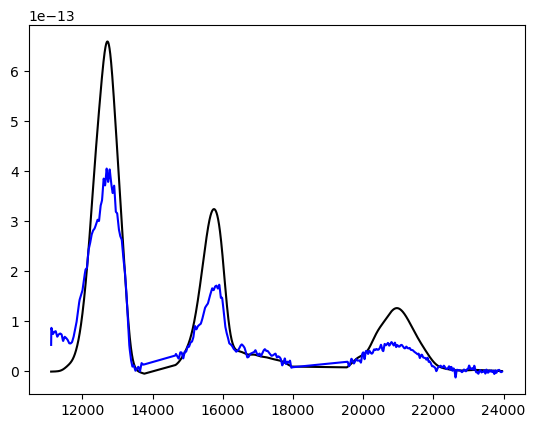

In [119]:
###################################################################
## Smooth and interpolate the SpeX T6 data onto the mosfire data ##
###################################################################

C_t6 = np.zeros(len(spex_T6))
G_t6 = np.zeros(len(spex_T6))
low_mod_t6 = np.zeros((len(spex_T6), 2, (len(wave))))
for i in range(len(spex_T6)):
    mod = np.loadtxt(spex_T6[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t6 = np.interp(wave, w, f)
    range_t6 = np.vstack([wave, interp_t6])
    low_mod_t6[i, :, :] = convolve_v2(range_t6, R, 1)
    C_t6[i] = (np.nansum((low_mod_t6[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t6[i, 1, :] ** 2 / unc ** 2))
    G_t6[i] = np.nansum(((low_mod_t6[i, 1, :] * smooth_t6_flux) / unc) ** 2)

Gt6_min = np.min(G_t6)
where_Gt6min = np.where(G_t6 == Gt6_min)
Ct6_min = C_t6[where_Gt6min]
modindex_t6 = int(where_Gt6min[0])
bestfit_t6 = np.loadtxt(spex_T6[modindex_t6])
bestmodel_t6 = spex_T6[modindex_t6]
residuals_t6 = f_smooth - low_mod_t6[modindex_t6, 1, :] * Ct6_min
print(np.average(residuals_t6))

print(f'Best fit: {bestmodel_t6}')
print(f'* Minimum C: {Ct6_min}\n* Minimum G: {Gt6_min}')

#plt.plot(wave, flux, color = 'black')
plt.plot(w_smooth, f_smooth, color = 'black')
plt.plot(low_mod_t6[modindex_t6, 0, :], low_mod_t6[modindex_t6, 1, :] * Ct6_min, color = 'blue')

1.4295523476623465e-14
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T6.5/spex-prism_2MASSJ12373919+6526148_20060408_T65.spex.txt
* Minimum C: [4.68345166e-13]
* Minimum G: 4.8265715797897406e+29


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_32994/1659757082.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t65 = int(where_Gt65min[0])


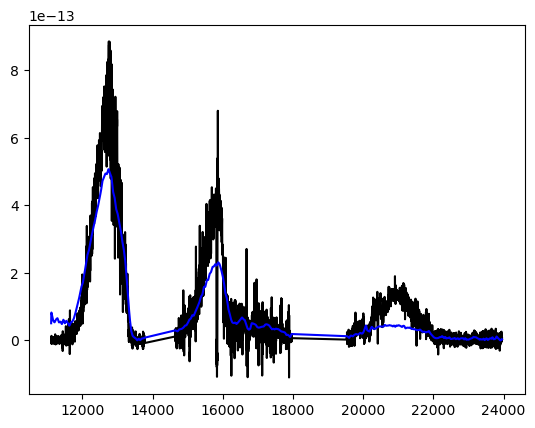

In [109]:
#####################################################################
## Smooth and interpolate the SpeX T6.5 data onto the mosfire data ##
#####################################################################

C_t65 = np.zeros(len(spex_T65))
G_t65 = np.zeros(len(spex_T65))
low_mod_t65 = np.zeros((len(spex_T65), 2, (len(wave))))
for i in range(len(spex_T65)):
    mod = np.loadtxt(spex_T65[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t65 = np.interp(wave, w, f)
    range_t65 = np.vstack([wave, interp_t65])
    low_mod_t65[i, :, :] = convolve_v2(range_t65, R, 1)
    C_t65[i] = (np.nansum((low_mod_t65[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t65[i, 1, :] ** 2 / unc ** 2))
    G_t65[i] = np.nansum(((low_mod_t65[i, 1, :] * smooth_t65_flux) / unc) ** 2)

Gt65_min = np.min(G_t65)
where_Gt65min = np.where(G_t65 == Gt65_min)
Ct65_min = C_t65[where_Gt65min]
modindex_t65 = int(where_Gt65min[0])
bestfit_t65 = np.loadtxt(spex_T65[modindex_t65])
bestmodel_t65 = spex_T65[modindex_t65]
residuals_t65 = flux - low_mod_t65[modindex_t6, 1, :] * Ct65_min
print(np.average(residuals_t65))

print(f'Best fit: {bestmodel_t65}')
print(f'* Minimum C: {Ct65_min}\n* Minimum G: {Gt65_min}')

plt.plot(wave, flux, color = 'black')
plt.plot(low_mod_t65[modindex_t65, 0, :], low_mod_t65[modindex_t65, 1, :] * Ct65_min, color = 'blue')

1.7112242249087096e-14
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7/spex-prism_2MASSJ00501994-3322402_20040907_T7.spex.txt
* Minimum C: [4.4631256e-13]
* Minimum G: 4.4572801179312945e+29


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_32994/301586664.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t7 = int(where_Gt7min[0])


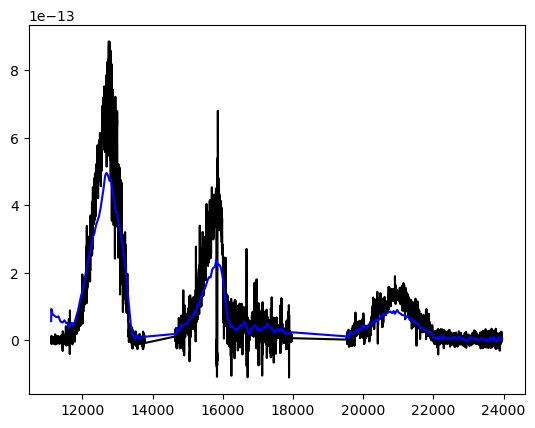

In [108]:
###################################################################
## Smooth and interpolate the SpeX T7 data onto the mosfire data ##
###################################################################

C_t7 = np.zeros(len(spex_T7))
G_t7 = np.zeros(len(spex_T7))
low_mod_t7 = np.zeros((len(spex_T7), 2, (len(wave))))
for i in range(len(spex_T7)):
    mod = np.loadtxt(spex_T7[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t7 = np.interp(wave, w, f)
    range_t7 = np.vstack([wave, interp_t7])
    low_mod_t7[i, :, :] = convolve_v2(range_t7, R, 1)
    C_t7[i] = (np.nansum((low_mod_t7[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t7[i, 1, :] ** 2 / unc ** 2))
    G_t7[i] = np.nansum(((low_mod_t7[i, 1, :] * smooth_t7_flux) / unc) ** 2)

Gt7_min = np.min(G_t7)
where_Gt7min = np.where(G_t7 == Gt7_min)
Ct7_min = C_t7[where_Gt7min]
modindex_t7 = int(where_Gt7min[0])
bestfit_t7 = np.loadtxt(spex_T7[modindex_t7])
bestmodel_t7 = spex_T7[modindex_t7]
residuals_t7 = flux - low_mod_t7[modindex_t7, 1, :] * Ct7_min
print(np.average(residuals_t7))

print(f'Best fit: {bestmodel_t7}')
print(f'* Minimum C: {Ct7_min}\n* Minimum G: {Gt7_min}')

plt.plot(wave, flux, color = 'black')
plt.plot(low_mod_t7[modindex_t7, 0, :], low_mod_t7[modindex_t7, 1, :] * Ct7_min, color = 'blue')

6.748817621227489e-15
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T7.5/spex-prism_HD3651B_20060903_T75.spex.txt
* Minimum C: [5.7054175e-13]
* Minimum G: 4.167226164222735e+29


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_32994/1972144220.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t75 = int(where_Gt75min[0])


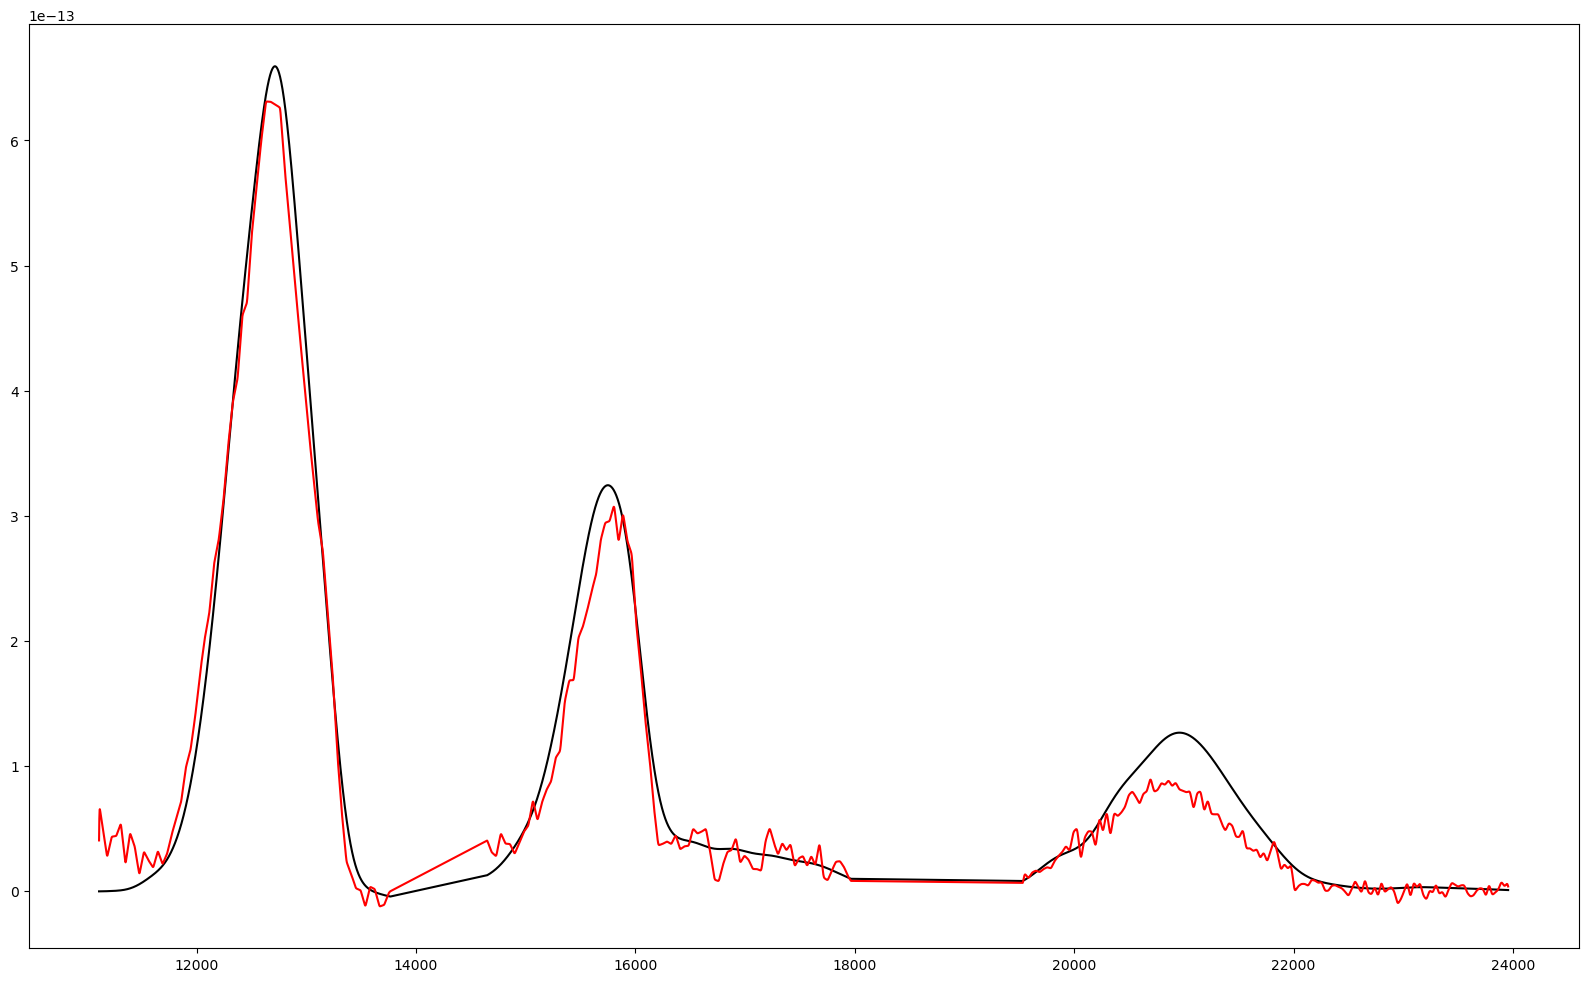

In [115]:
#####################################################################
## Smooth and interpolate the SpeX T6.5 data onto the mosfire data ##
#####################################################################

C_t75 = np.zeros(len(spex_T75))
G_t75 = np.zeros(len(spex_T75))
low_mod_t75 = np.zeros((len(spex_T75), 2, (len(wave))))
for i in range(len(spex_T75)):
    mod = np.loadtxt(spex_T75[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t75 = np.interp(wave, w, f)
    range_t75 = np.vstack([wave, interp_t75])
    low_mod_t75[i, :, :] = convolve_v2(range_t75, R, 1)
    C_t75[i] = (np.nansum((low_mod_t75[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t75[i, 1, :] ** 2 / unc ** 2))
    G_t75[i] = np.nansum(((low_mod_t75[i, 1, :] * smooth_t75_flux) / unc) ** 2)

Gt75_min = np.min(G_t75)
where_Gt75min = np.where(G_t75 == Gt75_min)
Ct75_min = C_t75[where_Gt75min]
modindex_t75 = int(where_Gt75min[0])
bestfit_t75 = np.loadtxt(spex_T75[modindex_t75])
bestmodel_t75 = spex_T75[modindex_t75]
residuals_t75 = f_smooth - low_mod_t75[modindex_t75, 1, :] * Ct75_min
print(np.average(residuals_t75))

print(f'Best fit: {bestmodel_t75}')
print(f'* Minimum C: {Ct75_min}\n* Minimum G: {Gt75_min}')

plt.figure(figsize = (20, 12))
#plt.plot(wave, flux, color = 'black')
plt.plot(w_smooth, f_smooth, color = 'black')
plt.plot(low_mod_t75[modindex_t75, 0, :], low_mod_t75[modindex_t75, 1, :] * Ct75_min, color = 'red')

1.091985410628012e-14
Best fit: /Users/bseamons/Documents/Research/SpeX_archived_spectra/Grouped/T8/spex-prism_2MASSJ09393548-2448279_20040312_T8.spex.txt
* Minimum C: [5.65598039e-13]
* Minimum G: 4.22362842039231e+29


/var/folders/36/1_bs4p6d4t73n8bdrm6msfsr0005tr/T/ipykernel_32994/1538016639.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  modindex_t8 = int(where_Gt8min[0])


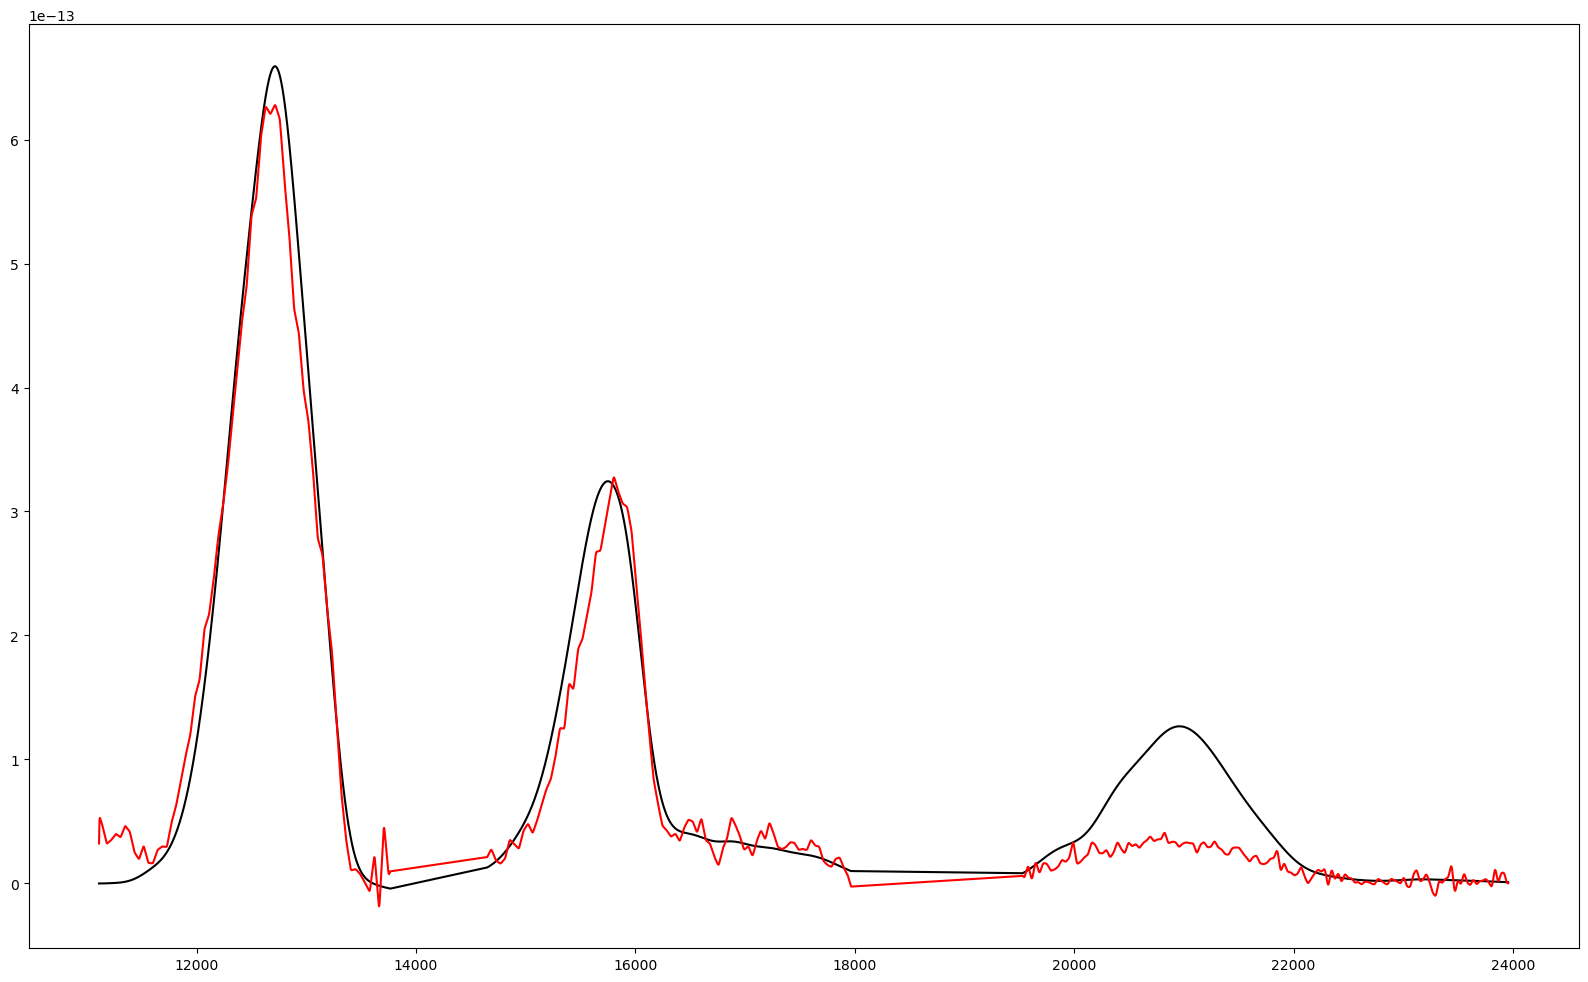

In [117]:
###################################################################
## Smooth and interpolate the SpeX T8 data onto the mosfire data ##
###################################################################

C_t8 = np.zeros(len(spex_T8))
G_t8 = np.zeros(len(spex_T8))
low_mod_t8 = np.zeros((len(spex_T8), 2, (len(wave))))
for i in range(len(spex_T8)):
    mod = np.loadtxt(spex_T8[i])
    w = mod[:, 0] * 1e4
    f = mod[:, 1]
    interp_t8 = np.interp(wave, w, f)
    range_t8 = np.vstack([wave, interp_t8])
    low_mod_t8[i, :, :] = convolve_v2(range_t8, R, 1)
    C_t8[i] = (np.nansum((low_mod_t8[i, 1, :] * flux) / unc ** 2)) / (np.nansum(low_mod_t8[i, 1, :] ** 2 / unc ** 2))
    G_t8[i] = np.nansum(((low_mod_t8[i, 1, :] * smooth_t8_flux) / unc) ** 2)

Gt8_min = np.min(G_t8)
where_Gt8min = np.where(G_t8 == Gt8_min)
Ct8_min = C_t8[where_Gt8min]
modindex_t8 = int(where_Gt8min[0])
bestfit_t8 = np.loadtxt(spex_T8[modindex_t8])
bestmodel_t8 = spex_T8[modindex_t8]
residuals_t8 = f_smooth - low_mod_t8[modindex_t8, 1, :] * Ct8_min
print(np.average(residuals_t8))

print(f'Best fit: {bestmodel_t8}')
print(f'* Minimum C: {Ct8_min}\n* Minimum G: {Gt8_min}')

plt.figure(figsize = (20, 12))
#plt.plot(wave, flux, color = 'black')
plt.plot(w_smooth, f_smooth, color = 'black')
plt.plot(low_mod_t8[modindex_t8, 0, :], low_mod_t8[modindex_t8, 1, :] * Ct8_min, color = 'red')

Average residual values:
T6:   2.907418551072467e-14
T6.5: 1.4295523476623465e-14
T7:   1.7112242249087096e-14
T7.5: 6.748817621227489e-15
T8:   1.091985410628012e-14


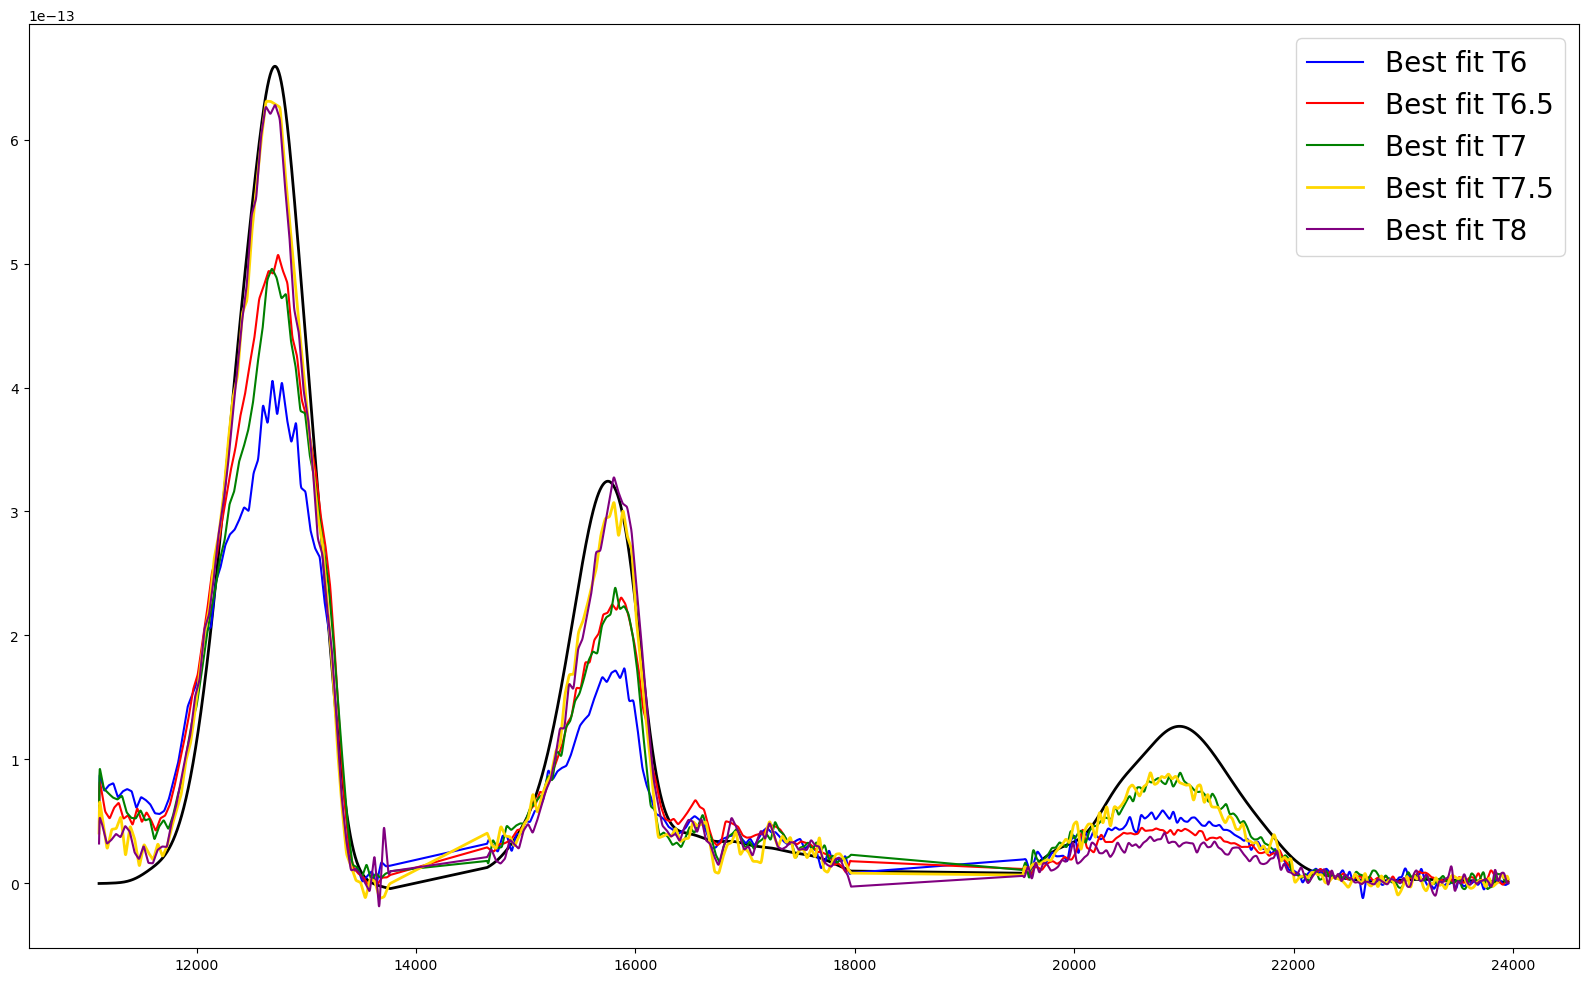

In [126]:
plt.figure(figsize = (20, 12))

#plt.plot(wave, flux, color = 'black')
plt.plot(w_smooth, f_smooth, color = 'black', linewidth = 2)
plt.plot(low_mod_t6[modindex_t6, 0, :], low_mod_t6[modindex_t6, 1, :] * Ct6_min, color = 'blue', label = 'Best fit T6')
plt.plot(low_mod_t65[modindex_t65, 0, :], low_mod_t65[modindex_t65, 1, :] * Ct65_min, color = 'red', label = 'Best fit T6.5')
plt.plot(low_mod_t7[modindex_t7, 0, :], low_mod_t7[modindex_t7, 1, :] * Ct7_min, color = 'green', label = 'Best fit T7')
plt.plot(low_mod_t75[modindex_t75, 0, :], low_mod_t75[modindex_t75, 1, :] * Ct75_min, color = 'gold', linewidth = 2, label = 'Best fit T7.5')
plt.plot(low_mod_t8[modindex_t8, 0, :], low_mod_t8[modindex_t8, 1, :] * Ct8_min, color = 'purple', label = 'Best fit T8')
plt.legend(loc = 'upper right', fontsize = 20)

print('Average residual values:')
print(f'T6:   {np.average(residuals_t6)}')
print(f'T6.5: {np.average(residuals_t65)}')
print(f'T7:   {np.average(residuals_t7)}')
print(f'T7.5: {np.average(residuals_t75)}')
print(f'T8:   {np.average(residuals_t8)}')